# Qiskit Notes I

***Last Update: May 14, 2022***

Covers:
* Circuit Level:
    * Quantum Circuit creation
    * Assigning parameters
    * Concatenate circuits
    * Instruction transfer
    * Observable through expectation values (manual and StateFn)

* Unitary Level:
    * Controlled gates (built-in and custom)
    * Custom gate from a given matrix
    * Transpose of Unitary
    * Convert a circuit to unitary

* Algorithm Level (more in implementation of each algorithm)

In [47]:
from sklearn import svm
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
from scipy.io import loadmat
import math

from qiskit import QuantumCircuit, Aer,QuantumRegister, transpile, execute
from qiskit.circuit import ParameterVector,Parameter
from qiskit.utils import QuantumInstance
from qiskit.circuit.library import ZFeatureMap, ZZFeatureMap, PauliFeatureMap
from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit.extensions import UnitaryGate
from qiskit.opflow import I,Z, StateFn
from qiskit.opflow.expectations import AerPauliExpectation
from qiskit.opflow.converters import CircuitSampler


import os
os.environ['QISKIT_IN_PARALLEL'] = 'TRUE'

SEED = 2508

# 1. Circuit Level

## 1.1. Quantum Circuit Creation

**Content:** How to create a quantum circuit either directly or using a QuantumRegister

**Resources:**
* __[QuantumCircuit](https://qiskit.org/documentation/stubs/qiskit.circuit.QuantumCircuit.html)__
* __[QuantumRegister](https://qiskit.org/documentation/stubs/qiskit.circuit.QuantumRegister.html)__

**Highlights:**
* `QuantumCircuit`: attribute `.data` returns all the instructions of the circuit
* `QuantumCircuit`: attribute `.qubits` returns a list of quantum bits in the other that the registers were added
* `QuantumCircuit`: method `.add_register` allows adding new register to an existing circuit (in place) without having to create a new circuit


**(1) Direct & Simple Creation**

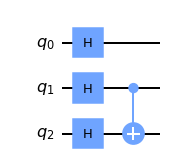

In [3]:
# Create a quantum circuit with 3 qubits and assign name "test circuit"
qc11a = QuantumCircuit(3,name="test circuit")
qc11a.h(range(qc11a.num_qubits))
qc11a.cx(1,2)
qc11a.draw('mpl')

**(2) Create quantum circuit with QuantumRegister**

NOTES:
* See Appendix A of __[OpenQASM](https://arxiv.org/pdf/1707.03429v2.pdf)__ for grammar rules; Grammar for name of register: [a-z][A-Za-z0-9_]*
* To create a `QuantumCircuit` using a `QuantumRegister`, should add a comma `,` after inputting the `QuantumRegister` - e.g., `qc = QuantumCircuit(qreg,)` to allow name to be shown when drawing the circuit


In [49]:
# Create the same 3-qubit quantum circuit using QuantumRegister
qreg11b = QuantumRegister(size=3,name="bath")

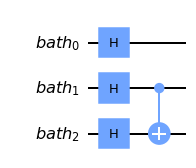

In [50]:
qc11b = QuantumCircuit(qreg11b,)

# Assign gates using qubit register (Qubit()) as the pointer
qc11b.h(qreg11b)
qc11b.cx(qreg11b[1],qreg11b[2])
qc11b.draw('mpl')

In [51]:
# Extract QuantumRegister information from quantum circuit
print(qc11b.qubits)
print(qc11a.qubits)
# See that for simply created circuit qc11a, default name of registers is 'q'

[Qubit(QuantumRegister(3, 'bath'), 0), Qubit(QuantumRegister(3, 'bath'), 1), Qubit(QuantumRegister(3, 'bath'), 2)]
[Qubit(QuantumRegister(3, 'q'), 0), Qubit(QuantumRegister(3, 'q'), 1), Qubit(QuantumRegister(3, 'q'), 2)]


## 1.2. Assigning Parameters

**Content:** How to assign parameters to a variational quantum circuit in an organized manner

**Resources:**
* __[Parameter](https://qiskit.org/documentation/stubs/qiskit.circuit.Parameter.html)__
* __[ParameterVector](https://qiskit.org/documentation/stubs/qiskit.circuit.ParameterVector.html)__


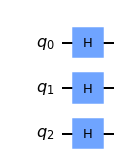

In [31]:
# Create a simple 3-qubit circuit
qc12a = QuantumCircuit(3)
qc12a.h(qc12a.qubits)
qc12a.draw('mpl')

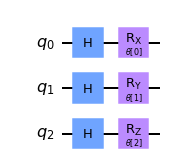

In [32]:
# Let's add in 3 parameterized rotation gates rx, ry, and rz
# Create ParameterVector of length 3 (an iterable of 3 Parameter instances)
params12a = ParameterVector("$\\theta$",length=3)

# Use ParameterVector to parameterize the rotation gates
qc12a.rx(params12a[0],qc12a.qubits[0])
qc12a.ry(params12a[1],qc12a.qubits[1])
qc12a.rz(params12a[2],qc12a.qubits[2])

qc12a.draw('mpl')

**NOTE:** Difference between __[`bind_parameters`](https://qiskit.org/documentation/stubs/qiskit.circuit.QuantumCircuit.bind_parameters.html#qiskit.circuit.QuantumCircuit.bind_parameters)__ and __[`assign_parameters`](https://qiskit.org/documentation/stubs/qiskit.circuit.QuantumCircuit.bind_parameters.html#qiskit.circuit.QuantumCircuit.assign_parameters)__:
* `bind_parameters(parameters)`: Assign numeric parameters to values yielding a new circuit (return a new copy with assignment substitution)
* `assign_parameters(parameters,inplace=False`: if inplace=False, similar to `bind_parameters`. If inplace=True, modifies the circuit and returns nothing

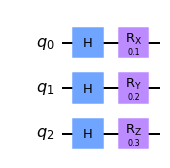

In [34]:
# Set an arbitrary value vector
params_vals12a = [0.1, 0.2, 0.3]
# Create a dictionary for organized binding (e.g., when the order of values might not be the same as the order of parameters in the circuit)
params_dict12a = {param : value for (param, value) in zip(params12a,params_vals12a)}
# Bind parameter values to the parameterized circuit
qc12a_assigned = qc12a.bind_parameters(params_dict12a)
qc12a_assigned.draw('mpl')

**NOTE:** The practice of creating a **{param : value}** dictionary is necessary for complex algorithms and should be abided by

## 1.3. Concatenate / Stack Circuits

**Content:** How to concatenate two circuits of the same width. How to create a quantum circuit combining different multi-qubit registers (to stack two circuits of arbitrary width with instructions in place, see 1.4. Instruction Transfer)

**Resources:**
* __[Combine quantum circuits Qiskit Video (super helpful)](https://www.youtube.com/watch?v=3ja8uCqUS0s)__ (Warning: circuit combination using Python addition operator is being deprecated, `QuantumCircuit.compose` is recommended instead)
* __[QuantumCircuit.compose](https://qiskit.org/documentation/stubs/qiskit.circuit.QuantumCircuit.compose.html#qiskit.circuit.QuantumCircuit.compose)__


**(a) Concatenate circuits of the same width**

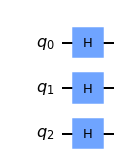

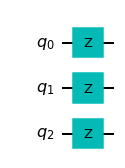

In [35]:
# Create two 3-qubit circuits
qc13a_1 = QuantumCircuit(3)
qc13a_1.h(qc13a_1.qubits)
qc13a_2 = QuantumCircuit(3)
qc13a_2.z(qc13a_2.qubits)
display(qc13a_1.draw('mpl'))
display(qc13a_2.draw('mpl'))

Circuit 1 + Circuit 2 Combination


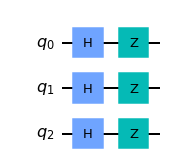

Circuit 2 + Circuit 1 Combination


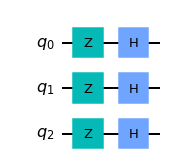

In [38]:
# Concatenate two circuits using compose()
print('Circuit 1 + Circuit 2 Combination')
qc13a_c1 = qc13a_1.compose(qc13a_2)
display(qc13a_c1.draw('mpl'))
print('Circuit 2 + Circuit 1 Combination')
qc13a_c2 = qc13a_2.compose(qc13a_1)
display(qc13a_c2.draw('mpl'))

**(b) Concatenate circuits of different widths**
NOTE:
* Both circuits should be constructed using QuantumRegister for organized concatenation (or else, one can also specify the qubits to concatenate onto within the method)
* `circuitA.compose(circuitB,...)` requires that `circuitA.num_qubits` >= `circuitB.num_qubits`

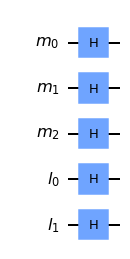

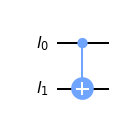

In [47]:
qr13b_m = QuantumRegister(3,name='m')
qr13b_l = QuantumRegister(2,name='l')

qc13b_1 = QuantumCircuit(qr13b_m,qr13b_l)
qc13b_1.h(qc13b_1.qubits)
qc13b_2 = QuantumCircuit(qr13b_l,)
qc13b_2.cx(0,1)

display(qc13b_1.draw('mpl'))
display(qc13b_2.draw('mpl'))

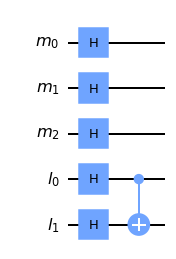

In [48]:
qc13b_c1 = qc13b_1.compose(qc13b_2,qc13b_2.qubits,inplace=False) # --> qc1.compose(qc2, qubits of qc1 to add onto)
qc13b_c1.draw('mpl')

**(c) Stack circuits**

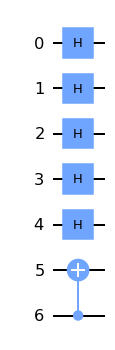

In [57]:
qc13c_1 = QuantumCircuit(QuantumRegister(2,name='k'),)
qc13c_1.cx(1,0)
# We want to stack qc13b_1 above qc13c_1
qc13c_c1 = QuantumCircuit(qc13b_1.qubits,qc13c_1.qubits,)
qc13c_c1.compose(qc13b_1,qubits=qc13b_1.qubits,inplace=True)
qc13c_c1.compose(qc13c_1,qubits=qc13c_1.qubits,inplace=True)
qc13c_c1.draw('mpl')

## 1.4. Circuit Data & Instruction Transfer

**Content:** How to extract instruction data from a circuit and transfer to another circuit

**Resources:**
* __[QuantumCircuit.append](https://qiskit.org/documentation/stubs/qiskit.circuit.QuantumCircuit.append.html#qiskit.circuit.QuantumCircuit.append)__

**NOTE**: `.compose` is for adding a `QuantumCircuit`, `.append` is for adding an `Instruction`


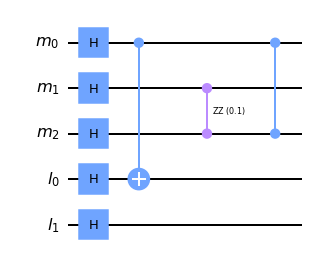

In [58]:
qr14_m = QuantumRegister(3,name='m')
qr14_l = QuantumRegister(2,name='l')

qc14_1 = QuantumCircuit(qr14_m,qr14_l)
qc14_1.h(qc14_1.qubits)
qc14_1.cx(0,3)
qc14_1.rzz(0.1,1,2)
qc14_1.cz(2,0)

qc14_1.draw('mpl')

In [63]:
# attribute `data` of a quantum circuit contains the list of instructions used in the circuit in order of application
qc14_1.data
# Each tuple in the list is in the format (instruction, qargs, cargs), where instruction is an Instruction (or subclass) object, qargs is a list of Qubit objects, and cargs is a list of Clbit objects.

[(Instruction(name='h', num_qubits=1, num_clbits=0, params=[]), [Qubit(QuantumRegister(3, 'm'), 0)], []), (Instruction(name='h', num_qubits=1, num_clbits=0, params=[]), [Qubit(QuantumRegister(3, 'm'), 1)], []), (Instruction(name='h', num_qubits=1, num_clbits=0, params=[]), [Qubit(QuantumRegister(3, 'm'), 2)], []), (Instruction(name='h', num_qubits=1, num_clbits=0, params=[]), [Qubit(QuantumRegister(2, 'l'), 0)], []), (Instruction(name='h', num_qubits=1, num_clbits=0, params=[]), [Qubit(QuantumRegister(2, 'l'), 1)], []), (Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), [Qubit(QuantumRegister(3, 'm'), 0), Qubit(QuantumRegister(2, 'l'), 0)], []), (Instruction(name='rzz', num_qubits=2, num_clbits=0, params=[0.1]), [Qubit(QuantumRegister(3, 'm'), 1), Qubit(QuantumRegister(3, 'm'), 2)], []), (Instruction(name='cz', num_qubits=2, num_clbits=0, params=[]), [Qubit(QuantumRegister(3, 'm'), 2), Qubit(QuantumRegister(3, 'm'), 0)], [])]

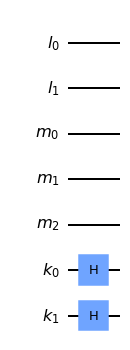

In [62]:
qc14_2 = QuantumCircuit(qr14_l,qr14_m,QuantumRegister(2,'k'))
qc14_2.h(QuantumRegister(2,'k'))
qc14_2.draw('mpl')

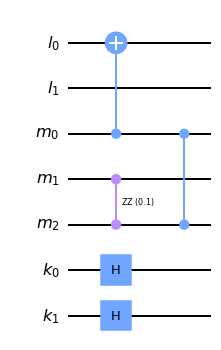

In [64]:
# Goal: add the last 3 instructions of qc14_1 onto qc14_2 while keeping the control/target registers consistent as before
for i in range(3):
    instruct_data = qc14_1.data[i-3] # --> tuple(instruction, qargs, cargs)
    qc14_2.append(instruction=instruct_data[0],qargs=instruct_data[1],cargs=instruct_data[2])
qc14_2.draw('mpl')

## 1.5. Expectation Observables

**Content:** How to program a specific expectation observable at the end of the circuit using StateFn

**Resources:**
* __[opflow.expectations](https://qiskit.org/documentation/stubs/qiskit.opflow.expectations.html)__
* __[CircuitSampler](https://qiskit.org/documentation/stubs/qiskit.opflow.converters.CircuitSampler.html)__
* __[QuantumInstance](https://qiskit.org/documentation/stubs/qiskit.utils.QuantumInstance.html)__
* __[OperatorBase](https://qiskit.org/documentation/stubs/qiskit.opflow.OperatorBase.html)__ (base class for all operators, including StateFn)
* __[StateFn](https://qiskit.org/documentation/stubs/qiskit.opflow.state_fns.StateFn.html)__
* __[Evaluating expectation values of operators in Qiskit (Blog)](https://quantumcomputing.stackexchange.com/questions/12080/evaluating-expectation-values-of-operators-in-qiskit)__


**(a) Sample expectation value from circuit using CircuitSampler**

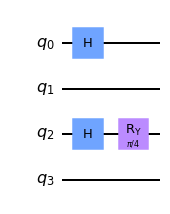

In [4]:
# Create a simple 4-qubit circuit
qc15a_1 = QuantumCircuit(4)
qc15a_1.h([0,2])
qc15a_1.ry(np.pi/4,2)
qc15a_1.draw('mpl')

In [20]:
# Construct an operator corresponding to measuring q0 in the computational basis (Z)
meas_q0 = I^3^Z
display(meas_q0)
# Construct an operator corresponding to measuring q0 and q2 in the computational basis (Z)
meas_q2 = I^Z^I^I
display(meas_q2)

PauliOp(Pauli('IIIZ'), coeff=1.0)

PauliOp(Pauli('IZII'), coeff=1.0)

**NOTE:** in qiskit, operators on the right correspond to the least significant qubit index, so in our case, to measure q0, the operator must be IIIZ, NOT ZIII

With the operator corresponding to the measurement defined, we then need to:
1) Convert the operator into a measurement state function using the constructor `StateFn(Op, measurement=True)` or `~StateFn(Op)`
2) Use one of the `Expectation` constructor (see *opflow.expectations* for the different expectations and see *Evaluating expectation values of operators in Qiskit* for the differences between them) to convert the measurement into a diagonal measurement (e.g., `AerPauliExpectation().convert(~StateFn(Op))`)
3) Compose the diagonal measurement onto the quantum circuit state function (e.g., `AerPauliExpectation().convert(~StateFn(Op)) @ StateFn(qc)`) (where `@` is the operation shorthand for the method `.compose` of `OperatorBase`)
4) Create a `CircuitSampler` and use it to convert the Operator to one in which the CircuitStateFns are replaced by DictStateFns or VectorStateFns (meaning the CircuitStateFns is replaced by the actual numerical StateFn at the end of the circuit). Under the hood, `.convert` calls `sample_circuits` on the CircuitStateFns to do the conversion. (e.g., `sampler = circ_samp.convert(AerPauliExpectation().convert(~StateFn(Op)) @ StateFn(qc))`, this give us the sampler handle
5) The expectation value can be calculated by calling `sampler.eval()`. If `PauliExpectation` was used in step 2, then every time `.eval()` is called the expectation value might be different since it is shot-based (other `Expectation` returns exact expectation value and is not shot-based, see the *Blog* in Resources for more info)

In [22]:
# Create a CircuitSampler
qinst_15a = QuantumInstance(Aer.get_backend('statevector_simulator'))
circ_samp_15a = CircuitSampler(qinst_15a) # or, input the backend directly into the CircuitSampler constructor

# Calculate expectation value when measuring q0 in the computational basis (Z) --> expect this to be 0
exp_val_15a_1 = circ_samp_15a.convert(AerPauliExpectation().convert(~StateFn(meas_q0)) @ StateFn(qc15a_1)).eval()
print('Expectation value of measuring q0 (IIIZ) is %.3f' % exp_val_15a_1)

# Calculate expectation value when measuring q2 in the computational basis (Z) --> expect this to be (-1)*cos(45/2)^2 + (+1)*cos((180-45)/2)^2 (on the bloch sphere, angles to 0 and 1 basis states are twice as large)
exp_val_15a_2 = circ_samp_15a.convert(AerPauliExpectation().convert(~StateFn(meas_q2)) @ StateFn(qc15a_1)).eval()
print('Expectation value of measuring q2 (IZII) is %.3f' % exp_val_15a_2)

Expectation value of measuring q0 (IIIZ) is 0.000
Expectation value of measuring q2 (IZII) is -0.707


**b) Sample expectation value of arbitrary measurement operator (need to first convert to combinations of Pauli operators)**

(still quite unclear how to do this)

Another simpler method of getting expectation value is to calculate the statevector

## 1.6. Direct circuit execution

**Content:** How to execute and get results from a circuit using "statevector_simulator" and "qasm_simulator" backends with `execute()` function or `QuantumInstance`

**Resources:**
* __[opflow.expectations](https://qiskit.org/documentation/stubs/qiskit.opflow.expectations.html)__

Quantum circuits for execution


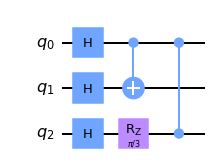

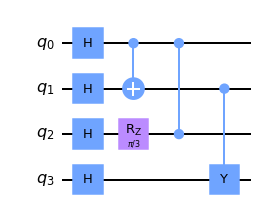

In [50]:
# Create quantum circuits for execution
qc16_1 = QuantumCircuit(3)
qc16_1.h(qc16_1.qubits)
qc16_1.rz(np.pi/3,2)
qc16_1.cx(0,1)
qc16_1.cz(0,2)
print("Quantum circuits for execution")
display(qc16_1.draw('mpl'))

qc16_2 = QuantumCircuit(4)
qc16_2.h(qc16_2.qubits)
qc16_2.rz(np.pi/3,2)
qc16_2.cx(0,1)
qc16_2.cz(0,2)
qc16_2.cy(1,3)
display(qc16_2.draw('mpl'))

qc16_list = [qc16_1,qc16_2]

In [65]:
sim_16_state = Aer.get_backend('statevector_simulator')
sim_16_qasm = Aer.get_backend('qasm_simulator')
qinst_16_state = QuantumInstance(backend=sim_16_state)
qinst_16_qasm = QuantumInstance(backend=sim_16_qasm)

**(a) Using `execute()` function**

In [58]:
# Single circuit execution
res_16a_state = execute(qc16_1, sim_16_state).result().get_statevector()
print(res_16a_state)
res_16a_qasm = execute(qc16_1.measure_all(inplace=False), sim_16_qasm).result().get_counts()
print(res_16a_qasm)

Statevector([ 0.30618622-0.1767767j,  0.30618622-0.1767767j,
              0.30618622-0.1767767j,  0.30618622-0.1767767j,
              0.30618622+0.1767767j, -0.30618622-0.1767767j,
              0.30618622+0.1767767j, -0.30618622-0.1767767j],
            dims=(2, 2, 2))
{'010': 146, '001': 151, '111': 116, '000': 121, '100': 138, '110': 133, '011': 112, '101': 107}


In [64]:
# Multiple circuits execution
res_16a_state_multi = execute(qc16_list, sim_16_state).result().get_statevector(1) # --> must indicate the index of the desired statevector if there are multiple circuits
print(res_16a_state_multi)

res_16a_qasm_multi = execute([qc.measure_all(inplace=False) for qc in qc16_list], sim_16_qasm).result().get_counts(1)
print(res_16a_qasm_multi)

Statevector([ 0.21650635-0.125j     ,  0.21650635-0.125j     ,
             -0.125     -0.21650635j, -0.125     -0.21650635j,
              0.21650635+0.125j     , -0.21650635-0.125j     ,
              0.125     -0.21650635j, -0.125     +0.21650635j,
              0.21650635-0.125j     ,  0.21650635-0.125j     ,
              0.125     +0.21650635j,  0.125     +0.21650635j,
              0.21650635+0.125j     , -0.21650635-0.125j     ,
             -0.125     +0.21650635j,  0.125     -0.21650635j],
            dims=(2, 2, 2, 2))
{'1111': 54, '0010': 75, '0100': 61, '1101': 66, '1001': 66, '0000': 68, '0011': 67, '0101': 61, '1010': 58, '1100': 57, '1110': 71, '0001': 59, '1011': 64, '0110': 84, '0111': 62, '1000': 51}


**(b) Using `QuantumInstance` class**

`QuantumInstance` allows for more complex option settings for the backend and enable running with real hardware backend. Other than that, the only difference to using `execute()` directly is that `.result()` does not need to be called before `.get_statevector()`

In [72]:
res_16b_state = qinst_16_state.execute(qc16_1).get_statevector() #--> after execution returns result directly, no need to call .result() before .get_statevector()
print(res_16b_state)


Statevector([ 0.30618622-0.1767767j,  0.30618622-0.1767767j,
              0.30618622-0.1767767j,  0.30618622-0.1767767j,
              0.30618622+0.1767767j, -0.30618622-0.1767767j,
              0.30618622+0.1767767j, -0.30618622-0.1767767j],
            dims=(2, 2, 2))


# 2. Unitary Level

## 2.1. Custom Controlled gate

**Content:** How to create a custom controlled gate - e.g., czz

**Resources:**
* __[Qiskit Tutorial on creating a custom gate](https://www.youtube.com/watch?v=krhPpzkT_z4)__



To create a custom gate from a circuit, use the method `.to_gate()` of class `QuantumCircuit`
To create a custom gate from a circuit with a set number of controlled qubits, use the method `.control(n_control_qubits)` following `.to_gate()`

Circuit to be converted to gate


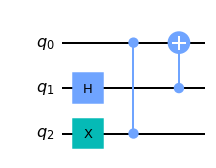

In [32]:
# Create a 3-qubit quantum circuit to be converted to a gate
qc21_a = QuantumCircuit(3)
qc21_a.h(1)
qc21_a.x(2)
qc21_a.cz(0,2)
qc21_a.cx(1,0)
print("Circuit to be converted to gate")
qc21_a.draw('mpl')

Custom gate applied to a new circuit


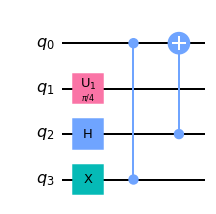

In [34]:
# Convert the circuit to a gate
custom_gate21 = qc21_a.to_gate()
# Append gate to a new circuit
qc_new_21a = QuantumCircuit(4)
qc_new_21a.t(1)
qc_new_21a.append(custom_gate21,[0,2,3])
print("Custom gate applied to a new circuit")
qc_new_21a.decompose().draw('mpl')

Controlled custom gate applied to a new circuit


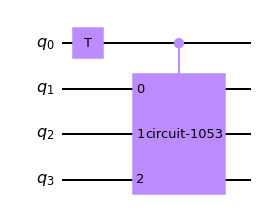

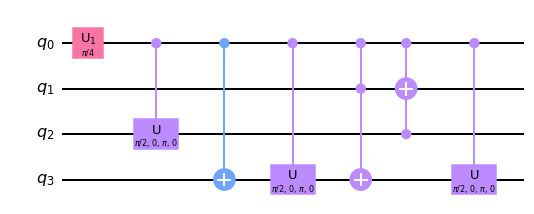

In [33]:
# Convert the circuit to a controlled gate
controlled_gate21 = qc21_a.to_gate().control(num_ctrl_qubits=1)
# Append gate to a new circuit
qc_new_21b = QuantumCircuit(4)
qc_new_21b.t(0)
qc_new_21b.append(controlled_gate21,[0,1,2,3])
# --> in this list, the first (num_ctrl_qubits) elements are indices of the control qubits, the rest are the qubits to map the controlled gate onto. In this case, 0 is the single control qubit and the controlled gate is map onto qubit 1,2, and 3

print("Controlled custom gate applied to a new circuit")
display(qc_new_21b.draw('mpl'))
display(qc_new_21b.decompose().draw('mpl'))

## 2.2. Apply custom gate using a given unitary matrix

**Content:** How to create a custom unitary from a given numerical matrix (using `.unitary` of the class `QuantumCircuit`)

**Resources:**
* __[Qiskit Tutorial on converting a matrix to a unitary](https://www.youtube.com/watch?v=O2WcZS4yO1Q)__
* __[compiler.transpile (function)](https://qiskit.org/documentation/stubs/qiskit.compiler.transpile.html)__
* __[Circuit Library](https://qiskit.org/documentation/apidoc/circuit_library.html)__ (reference on U1, U2, U3 and other gates)



In [35]:
# Specify a numerical unitary matrix (this can be a 2D Python list or a 2D numpy matrix)
U = [[1,0,0,0],
     [0,0,0,1],
     [0,1,0,0],
     [0,0,1,0]]

Custom unitary applied to a circuit


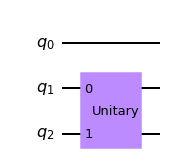

In [39]:
# Apply the custom unitary to a circuit
qc22_a = QuantumCircuit(3)
qc22_a.unitary(U,[1,2])
print("Custom unitary applied to a circuit")
display(qc22_a.draw('mpl'))

Transpiled circuit in the basis [CX,U3]


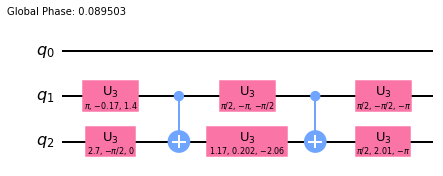

In [40]:
# Transpile the unitary circuit using a given set of basis gate
trans_qc22_a = transpile(qc22_a,basis_gates=['cx','u3']) # --> u3 is the arbitrary single qubit rotation gate and thus makes a universal basis
print("Transpiled circuit in the basis [CX,U3]")
trans_qc22_a.draw('mpl')

## 2.3. Transpose unitary

**Content:** To inverse a quantum circuit (e.g., for use in quantum kernel in QSVM), use the method `.inverse()` from the class `QuantumCircuit`

**Resources:**
* __[Qiskit Tutorial on inverting a quantum circuit](https://www.youtube.com/watch?v=SiPF2SVb7xc)__

**NOTE:** `.inverse()` does not work if there is a non-unitary operation in the circuit (e.g., any measurement)



Original Circuit


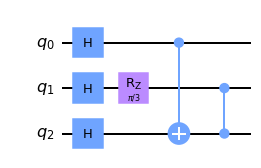

In [43]:
# Create a 3-qubit quantum circuit
qc23_a = QuantumCircuit(3)
qc23_a.h(qc23_a.qubits)
qc23_a.rz(np.pi/3,1)
qc23_a.cx(0,2)
qc23_a.cz(1,2)
print("Original Circuit")
qc23_a.draw('mpl')

Inverted circuit


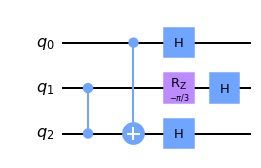

In [44]:
# Invert the circuit using the .inverse() method
qc23_a_inv = qc23_a.inverse()
print("Inverted circuit")
qc23_a_inv.draw('mpl')

## 2.4. Convert a circuit to unitary matrix

**Content:** How to get the unitary matrix corresponding to a quantum circuit

**Resources:**
* __[Qiskit Tutorial on Unitary Simulator](https://www.youtube.com/watch?v=5uT5fUq2HVM)__

**NOTE:** There will be small numerical error in the conversion

Original Circuit


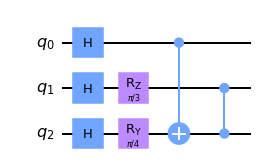

In [45]:
# Create a general 3-qubit circuit
qc24_a = QuantumCircuit(3)
qc24_a.h(qc24_a.qubits)
qc24_a.rz(np.pi/3,1)
qc24_a.ry(np.pi/4,2)
qc24_a.cx(0,2)
qc24_a.cz(1,2)
print("Original Circuit")
qc24_a.draw('mpl')

In [49]:
simulator_24 = Aer.get_backend('unitary_simulator')
unitary_24 = execute(qc24_a,simulator_24).result().get_unitary()
unitary_24

Operator([[ 0.16570679-0.09567086j,  0.16570679-0.09567086j,
            0.16570679-0.09567086j,  0.16570679-0.09567086j,
            0.40005157-0.23096988j,  0.40005157-0.23096988j,
            0.40005157-0.23096988j,  0.40005157-0.23096988j],
          [ 0.40005157-0.23096988j, -0.40005157+0.23096988j,
            0.40005157-0.23096988j, -0.40005157+0.23096988j,
           -0.16570679+0.09567086j,  0.16570679-0.09567086j,
           -0.16570679+0.09567086j,  0.16570679-0.09567086j],
          [ 0.16570679+0.09567086j,  0.16570679+0.09567086j,
           -0.16570679-0.09567086j, -0.16570679-0.09567086j,
            0.40005157+0.23096988j,  0.40005157+0.23096988j,
           -0.40005157-0.23096988j, -0.40005157-0.23096988j],
          [ 0.40005157+0.23096988j, -0.40005157-0.23096988j,
           -0.40005157-0.23096988j,  0.40005157+0.23096988j,
           -0.16570679-0.09567086j,  0.16570679+0.09567086j,
            0.16570679+0.09567086j, -0.16570679-0.09567086j],
          [ 0.400051